In [1]:
%matplotlib inline
from __future__ import division
import networkx as nx
import ipaddress
import numpy as np
import glob
import collections
import seaborn as sns
import pandas as pd
import powerlaw
import matplotlib.pyplot as plt
from caida_to_graph import get_pytree

In [1]:
default_dir = '../../home/app/data/'
routeviews_file

In [2]:
def ip_to_as_graph(G):
    as_edges = []
    count = 0
    for i,(v1,v2) in enumerate(G.edges()):
        try:
            asn1 = pyt.get(str(v1))
            asn2 = pyt.get(str(v2))
            if asn1 is not None and asn2 is not None:
                as_edges.append((asn1,asn2))
            else:
                count =  count + 1
        except:
            pass
    G1 = nx.Graph()
    G1.add_edges_from(as_edges)
    print count
    return G1

## Load asn country

Information extracted from https://www.cc2asn.com/#http

In [3]:
file_list = glob.glob(default_dir+'asn/*_asn')

In [4]:
asn_cc = {}
for fi in file_list:
    with open(fi, "r") as f:
        for i, l in enumerate(f):
            asn_cc[int(l[2:])] = fi.split("_")[0]

### Load prefix tree

Information extracted from https://www.caida.org/data/routing/routeviews-prefix2as.xml

In [5]:
pyt = get_pytree(default_dir + "routeviews-rv6-20170908-1200.pfx2as")

## Get prefixes in latam

In [6]:
with open(default_dir + "routeviews-rv6-20170908-1200.pfx2as", "r") as f:
    pref = []
    for l in f:
        a, b, c = l.split("\t")
        ntw = ipaddress.ip_network("/".join([a,b]).decode("unicode-escape"))
        pref.append((ntw,c))

In [7]:
print len(pref)

46039


In [8]:
lat1 = ipaddress.ip_network(u"2800::/12")
lat2 = ipaddress.ip_network(u"2001:1200::/23")

In [9]:
lat_pref = []
for x in pref:
    if lat1.overlaps(x[0]) or lat2.overlaps(x[0]):
        lat_pref.append(x)
len(lat_pref)

6428

In [10]:
latam_asn = set( int(asn.strip()) for ntw, asn in lat_pref if "_" not in asn) # Only numbers as a set
len(latam_asn)

2317

## ASN covered in targets of cuca

In [11]:
with open("targets.ip", "r") as f: targets = [x.strip() for x in f.readlines()]

In [12]:
used_asn_cuca = set()
for x in targets:
    try:
        asn = pyt.get(x)
        used_asn_cuca.add(asn)
    except:
        pass

In [13]:
len(used_asn_cuca)

1309

In [14]:
"""
What porcentage of the available latam asn where targeted
"""
intersection_cuca_all = used_asn_cuca.intersection(latam_asn)
print len(intersection_cuca_all) / len(latam_asn)

0.564523090203


## ASN covered in targets of caida

In [15]:
with open('all_proc.csv', 'r') as f: caida_targets = [x.strip() for x in f.readlines() if x[0]=="H"]

In [16]:
caida_t = [x.split(",")[2] for x in caida_targets]

In [18]:
used_asn_caida = set()
for x in caida_t:
    try:
        asn = pyt.get(x)
        used_asn_caida.add(asn)
    except:
        pass

In [19]:
"""
What porcentage of the available latam asn where targeted
"""
intersection_caida_all = used_asn_caida.intersection(latam_asn)
print len(intersection_caida_all) / len(latam_asn)

0.987483815278


## Load caida topology

In [20]:
with open("caida2.links", "r") as f: G_caida = nx.read_edgelist(f, delimiter=",")

### Basic statistics

In [21]:
print 'Edges: ',G_caida.number_of_edges()
print 'Nodes: ',G_caida.number_of_nodes()

Edges:  5263146
Nodes:  4651387


### Make subgraph only involving LACNIC nodes and neighbours

In [22]:
subset_caida = set()
for i,x in enumerate(G_caida.nodes_iter()):
    aux = ipaddress.ip_address(x)
    if aux in lat1 or aux in lat2:
        subset_caida.add(x)
        subset_caida.update(G_caida.neighbors(x))

H_caida = G_caida.subgraph(subset_caida)

In [23]:
print 'Edges: ',H_caida.number_of_edges()
print 'Nodes: ',H_caida.number_of_nodes()

Edges:  719528
Nodes:  653691


### Make AS caida

In [28]:
G_as_caida = ip_to_as_graph(G_caida)
print 'Edges: ', G_as_caida.number_of_edges()
print 'Nodes: ', G_as_caida.number_of_nodes()

563594
Edges:  88903
Nodes:  13681


#### All properties to a table

In [77]:
all_caida = [G_caida, H_caida, G_as_caida]
data = []
for G in all_caida:
    data_i = []
    data_i.append(G.number_of_nodes())
    data_i.append(G.number_of_edges())
    data_i.append(nx.average_clustering(G))
    fitted = powerlaw.Fit(G.degree().values(),verbose=False)
    data_i.append(fitted.alpha)
    data.append(data_i)

df = pd.DataFrame(data)
df.columns = ['$| V |$', '$| E |$', '$\overline{c}$', '$\gamma$']
print df.to_latex(escape=False)

\begin{tabular}{lrrrr}
\toprule
{} &  $| V |$ &  $| E |$ &  $\overline{c}$ &   $\gamma$ \\
\midrule
0 &  4651387 &  5263146 &        0.001686 &   2.330830 \\
1 &   653691 &   719528 &        0.002035 &  16.059418 \\
2 &    13681 &    88903 &        0.683887 &   2.765026 \\
\bottomrule
\end{tabular}



In [80]:
fitted  = powerlaw.Fit(H_caida.degree().values(),verbose=False)

In [84]:
fitted2  = powerlaw.Fit(G_caida.degree().values(),verbose=False)

In [85]:
fitted2.

0.03077526825563897

In [99]:
R, p = fitted2.distribution_compare('power_law', 'lognormal_positive')

In [96]:
fitted_as  = powerlaw.Fit(G_as_caida.degree().values(),verbose=False)
print fitted_as.xmin

7.0


In [98]:
R, p = fitted_as.distribution_compare('power_law', 'lognormal_positive')
print R,p

303.797450496 1.70846399724e-24


In [100]:
print R,p

2.03966627987 0.536269138624


In [83]:
fitted.sigma

0.018626100257498765

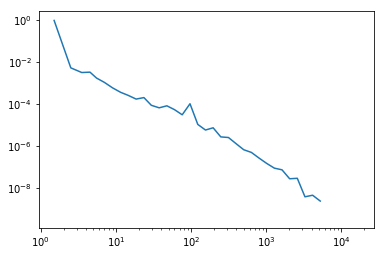

In [89]:
fitted.plot_pdf()

## Load cuca topology

In [40]:
with open("sample2.links", "r") as f: G_cuca = nx.read_edgelist(f, delimiter=",")

Basic statistics

In [41]:
print 'Edges: ',G_cuca.number_of_edges()
print 'Nodes: ',G_cuca.number_of_nodes()

Edges:  165374
Nodes:  37905


### Make subgraph only involving LACNIC nodes and neighbours

In [42]:
subset_cuca = set()
for i,x in enumerate(G_cuca.nodes_iter()):
    aux = ipaddress.ip_address(x)
    if aux in lat1 or aux in lat2:
        subset_cuca.add(x)
        subset_cuca.update(G_cuca.neighbors(x))

H_cuca = G_cuca.subgraph(subset_cuca)

Basic statistics

In [43]:
print 'Edges: ',H_cuca.number_of_edges()
print 'Nodes: ',H_cuca.number_of_nodes()

Edges:  157917
Nodes:  35625


### Make AS graph

In [44]:
G_as_cuca = ip_to_as_graph(G_cuca)
print 'Edges: ', G_as_cuca.number_of_edges()
print 'Nodes: ', G_as_cuca.number_of_nodes()

21176
Edges:  11412
Nodes:  1386


### All properties to table

In [75]:
all_cuca = [G_cuca, H_cuca, G_as_cuca]
data = []
for G in all_cuca:
    data_i = []
    data_i.append(G.number_of_nodes())
    data_i.append(G.number_of_edges())
    data_i.append(nx.average_clustering(G))
    fitted = powerlaw.Fit(G.degree().values(),verbose=False)
    data_i.append(fitted.alpha)
    data_i.append(fitted.xmin)
    data.append(data_i)

In [76]:
df = pd.DataFrame(data)
df.columns = ['$| V |$', '$| E |$', '$\overline{c}$', '$\gamma$', 'xmin']
print df.to_latex(escape=False)

\begin{tabular}{lrrrrr}
\toprule
{} &  $| V |$ &  $| E |$ &  $\overline{c}$ &  $\gamma$ &  xmin \\
\midrule
0 &    37905 &   165374 &        0.222225 &  2.407465 &   8.0 \\
1 &    35625 &   157917 &        0.233024 &  2.381923 &   8.0 \\
2 &     1386 &    11412 &        0.779170 &  2.552826 &   8.0 \\
\bottomrule
\end{tabular}



# Analysis

### How many of the targeted latam ases are present in an edge?

In [47]:
both_as = [G_as_caida, G_as_cuca]
used_both = [intersection_caida_all, intersection_cuca_all]

In [48]:
for i,G in enumerate(both_as):
    print len(set(G.nodes()).intersection(used_both[i])) / len(used_both[i])

1.0
1.0


### How many latam - latam edges where found?

In [49]:
latam_edges_both = [set(),set()]
for i,G in enumerate(both_as):
    for v1, v2 in G.edges():
        if v1 in latam_asn and v2 in latam_asn:
            latam_edges_both[i].add(tuple(sorted([v1,v2])))
    print len(latam_edges_both[i])

5403
9708


## How related are both graph edges?

In [50]:
in_both = latam_edges_both[0].intersection(latam_edges_both[1])
print len(in_both)

2703


In [51]:
only_cuca = latam_edges_both[1].difference(latam_edges_both[0])
print len(only_cuca)

7005


In [52]:
only_caida = latam_edges_both[0].difference(latam_edges_both[1])
print len(only_caida)

2700


#### How many discovered in caida could have been discovered because both asn where targets but where not?

In [53]:
count = 0
for (v1,v2) in only_caida:
    if (v1 in intersection_cuca_all) and (v2 in intersection_cuca_all):
        count = count + 1
print count

1099


#### How many edges discovered in cuca but not in caida where in ases targeted by caida?

In [54]:
count = 0
for (v1,v2) in only_cuca:
    if (v1 in intersection_caida_all) and (v2 in intersection_caida_all):
        count = count + 1
print count / len(only_cuca)

0.995431834404


### Trying to find why the results wheren't not so good

In [117]:
used_asn_caida_count = []
for x in caida_t:
    try:
        used_asn_caida_count.append(pyt.get_key(x))
    except:
        pass
    
len(used_asn_caida_count)

8893176

In [119]:
used_asn_cuca_count = []
for x in targets:
    try:
        used_asn_cuca_count.append(pyt.get_key(x))
    except:
        pass
    
len(used_asn_cuca_count)

20741

In [120]:
caida_prefix_count = collections.Counter(used_asn_caida_count)
cuca_prefix_count = collections.Counter(used_asn_cuca_count)

In [110]:
cuca_count = []
for x,y in lat_pref:
    cuca_count.append(cuca_prefix_count[x.with_prefixlen])

In [111]:
caida_count = []
for x,y in lat_pref:
    caida_count.append(caida_prefix_count[x.with_prefixlen])

In [129]:
cc = np.array(caida_count)
cu = np.array(cuca_count)
print 'Cant caida: ', sum(cc), ' mean: ', cc.mean(), ' sdev: ', cc.std()
print 'Cant cuca: ',  sum(cu), ' mean: ', cu.mean(), ' sdev: ', cu.std()

Cant caida:  1210942  mean:  188.385500933  sdev:  103.826066146
Cant cuca:  20226  mean:  3.14654635968  sdev:  55.4098015111


## Export Data

In [56]:
nx.write_edgelist(G=G_as_cuca,path='cuca_as.edgelist')

In [103]:
nx.write_edgelist(path='edgelist.cuca',G=G_as_cuca)

In [104]:
nx.write_edgelist(path='edgelist.caida',G=G_as_caida)